In [3]:
%pip install numpy pandas scikit-learn matplotlib
import os
import numpy as np
import pandas as pd
from dataclasses import dataclass
import math
from typing import List, Dict
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from scipy.stats import pointbiserialr, chi2_contingency
import matplotlib.pyplot as plt

print("Dependencies and imports set up.")

Note: you may need to restart the kernel to use updated packages.
Dependencies and imports set up.


In [4]:
# Define data class for track points
@dataclass
class TrackPoint:
    frame_id: int
    x: float
    y: float
    zone_id: int

VehicleTrack = List[TrackPoint]

# TrafficAnalyzer class with updated feature extraction
class TrafficAnalyzer:
    def __init__(self, fps: float, speed_limit: float, zone_definitions: Dict, gsd: float, center_x: float, center_y: float, radius_outer: float):
        """Initialize with project-specific parameters."""
        self.fps = fps
        self.speed_limit = speed_limit
        self.zone_definitions = zone_definitions
        self.gsd = gsd  # Ground sample distance in meters/pixel
        self.center_x = center_x  # Roundabout center x-coordinate
        self.center_y = center_y  # Roundabout center y-coordinate
        self.radius_outer = radius_outer  # Outer radius of the inner ring

    def calculate_speed(self, track: VehicleTrack) -> List[float]:
        """Calculate speed in km/h between consecutive points."""
        speeds = []
        for i in range(1, len(track)):
            dx = (track[i].x - track[i-1].x) * self.gsd
            dy = (track[i].y - track[i-1].y) * self.gsd
            distance = math.sqrt(dx**2 + dy**2)
            time = (track[i].frame_id - track[i-1].frame_id) / self.fps
            speed_mps = distance / time if time > 0 else 0
            speed_kmph = speed_mps * 3.6
            speeds.append(speed_kmph)
        return speeds
    
    def calculate_acceleration(self, track: VehicleTrack) -> List[float]:
        speeds = self.calculate_speed(track)
        accels = []
        for i in range(1, len(speeds)):
            time = (track[i+1].frame_id - track[i].frame_id) / self.fps
            accel = (speeds[i] - speeds[i-1]) / time if time > 0 else 0
            accels.append(accel)
        return accels

    def calculate_speed_variance(self, track: VehicleTrack) -> float:
        """Calculate variance of speeds to capture erratic speed changes."""
        speeds = self.calculate_speed(track)
        return np.var(speeds) if speeds else 0.0

    def calculate_turn_angle(self, track: VehicleTrack) -> List[float]:
        """Calculate turn angles in degrees using three consecutive points."""
        angles = []
        for i in range(2, len(track)):
            v1 = (track[i-1].x - track[i-2].x, track[i-1].y - track[i-2].y)
            v2 = (track[i].x - track[i-1].x, track[i].y - track[i-1].y)
            dot_product = v1[0] * v2[0] + v1[1] * v2[1]
            mag_v1 = math.sqrt(v1[0]**2 + v1[1]**2)
            mag_v2 = math.sqrt(v2[0]**2 + v2[1]**2)
            if mag_v1 * mag_v2 == 0:
                angles.append(0)
                continue
            cos_theta = min(1.0, max(-1.0, dot_product / (mag_v1 * mag_v2)))
            angle = math.degrees(math.acos(cos_theta))
            angles.append(angle)
        return angles

    def get_zone_sequence(self, track: VehicleTrack) -> List[int]:
        """Return sequence of zone IDs."""
        return [point.zone_id for point in track]

    def calculate_trip_duration(self, track: VehicleTrack) -> float:
        """Calculate trip duration in seconds."""
        if len(track) < 2:
            return 0.0
        return (track[-1].frame_id - track[0].frame_id) / self.fps

    def calculate_number_of_sharp_turns(self, track: VehicleTrack, angle_threshold: float = 20.0) -> int:
        """Count turns exceeding angle threshold (degrees)."""
        angles = self.calculate_turn_angle(track)
        return sum(1 for angle in angles if angle > angle_threshold)

    def calculate_zone_transition_count(self, track: VehicleTrack) -> int:
        """Count number of zone changes."""
        zone_seq = self.get_zone_sequence(track)
        if len(zone_seq) < 2:
            return 0
        return sum(1 for i in range(1, len(zone_seq)) if zone_seq[i] != zone_seq[i-1])

    def calculate_direction_variance(self, track: VehicleTrack) -> float:
        """Calculate variance of turn angles in (degrees)^2."""
        angles = self.calculate_turn_angle(track)
        return np.var(angles) if angles else 0.0

    def calculate_circular_adherence(self, track: VehicleTrack) -> float:
        """Calculate adherence to circular path based on deviation from expected radius."""
        if len(track) < 2:
            return 0.0
        distances = [math.sqrt((p.x - self.center_x)**2 + (p.y - self.center_y)**2) for p in track]
        if not distances:
            return 0.0
        expected_radius = np.median(distances)  # Median as a robust estimate
        if expected_radius == 0:
            return 0.0
        std_deviation = np.std(distances)  # Variability from circular path
        adherence = 1 / (1 + std_deviation / expected_radius)  # Normalized measure
        return max(0.0, min(1.0, adherence))

    def get_entry_exit_zones(self, track: VehicleTrack) -> tuple[int, int]:
        """Get the entry and exit zones of the trajectory."""
        if not track:
            return -1, -1
        return track[0].zone_id, track[-1].zone_id

    def is_same_entry_exit(self, track: VehicleTrack) -> int:
        """Check if the trajectory enters and exits the same zone (potential abnormality)."""
        entry, exit = self.get_entry_exit_zones(track)
        return 1 if entry == exit and entry != -1 else 0

    def calculate_path_efficiency(self, track: VehicleTrack) -> float:
        """Calculate path efficiency as straight-line distance divided by actual path length."""
        if len(track) < 2:
            return 0.0
        actual_distance = sum(
            math.sqrt((track[i].x - track[i-1].x)**2 + (track[i].y - track[i-1].y)**2)
            for i in range(1, len(track))
        )
        straight_line_distance = math.sqrt((track[-1].x - track[0].x)**2 + (track[-1].y - track[0].y)**2)
        return straight_line_distance / actual_distance if actual_distance > 0 else 1.0

print("TrafficAnalyzer class defined with enhanced features.")

TrafficAnalyzer class defined with enhanced features.


In [5]:
# Function to derive roundabout geometry from normal trajectories
def derive_roundabout_geometry(normal_trajectories: List[pd.DataFrame]) -> tuple[float, float, float]:
    """Derive center and radius of the roundabout from normal trajectories using clustering."""
    all_points = []
    for traj_df in normal_trajectories:
        track = convert_df_to_track(traj_df, 0, 0, 100.0, 500.0)  # Initial broad range
        points = [(p.x, p.y) for p in track]
        all_points.extend(points)
    
    if not all_points:
        print("Warning: No points found in normal trajectories. Using defaults.")
        return 0.0, 0.0, 100.0
    
    kmeans = KMeans(n_clusters=1, random_state=42).fit(all_points)
    center_x, center_y = kmeans.cluster_centers_[0]
    distances = pairwise_distances(all_points, [[center_x, center_y]]).flatten()
    radius_outer = np.percentile(distances, 90)  # Use 90th percentile for robustness
    radius_inner = radius_outer / 2  # Assume inner radius is half of outer
    
    print(f"Derived roundabout geometry: center_x={center_x:.2f}, center_y={center_y:.2f}, radius_outer={radius_outer:.2f}, radius_inner={radius_inner:.2f}")
    return center_x, center_y, radius_outer

# Helper function to assign zones
def assign_zone_id(x: float, y: float, center_x: float, center_y: float, radius_inner: float, radius_outer: float) -> int:
    """Assign zone based on distance and angle from roundabout center."""
    dx = x - center_x
    dy = y - center_y
    distance = math.sqrt(dx**2 + dy**2)
    angle = math.degrees(math.atan2(dy, dx)) % 360
    
    if distance < radius_inner:
        return 0  # Center (roundabout island)
    elif distance < radius_outer:
        return 1  # Inner ring (circulating path)
    else:
        if 0 <= angle < 90:
            return 2  # North-East entry/exit
        elif 90 <= angle < 180:
            return 3  # South-East
        elif 180 <= angle < 270:
            return 4  # South-West
        else:
            return 5  # North-West

# Helper function to convert DataFrame to VehicleTrack
def convert_df_to_track(df: pd.DataFrame, center_x: float, center_y: float, radius_inner: float, radius_outer: float) -> VehicleTrack:
    """Convert DataFrame to VehicleTrack with zone assignment."""
    track = []
    for _, row in df.iterrows():
        x = row['left'] + row['w'] / 2
        y = row['top'] + row['h'] / 2
        zone_id = assign_zone_id(x, y, center_x, center_y, radius_inner, radius_outer)
        track.append(TrackPoint(frame_id=int(row['frameNo']), x=x, y=y, zone_id=zone_id))
    return track

# Helper function to load trajectories
def load_trajectories(video_folder: str) -> tuple[List[pd.DataFrame], List[int]]:
    """Load trajectories from normal and abnormal subfolders."""
    normal_path = os.path.join(video_folder, 'normal')
    abnormal_path = os.path.join(video_folder, 'abnormal')
    trajectories, labels = [], []

    for path, label in [(normal_path, 0), (abnormal_path, 1)]:
        if os.path.exists(path):
            files = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.csv')]
            for file in files:
                df = pd.read_csv(file)[['frameNo', 'left', 'top', 'w', 'h']].sort_values(by='frameNo')
                track_id = int(file.split('/')[-1].split('_')[0])
                print(f"Loaded {os.path.basename(file)} from {'normal' if label == 0 else 'abnormal'} folder with {len(df)} rows for track ID {track_id}.")
                trajectories.append(df)
                labels.append(label)
    return trajectories, labels

print("Helper functions defined.")

Helper functions defined.


In [ ]:
def extract_features_for_all_trajectories(trajectories: List[pd.DataFrame], labels: List[int], analyzer: TrafficAnalyzer) -> pd.DataFrame:
    results = []
    valid_sequences = {'2,1,3', '3,1,4', '4,1,5', '5,1,2'}
    for idx, (traj_df, label) in enumerate(zip(trajectories, labels)):
        track = convert_df_to_track(traj_df, analyzer.center_x, analyzer.center_y, analyzer.radius_outer/2, analyzer.radius_outer)
        speeds = analyzer.calculate_speed(track)
        accels = analyzer.calculate_acceleration(track)
        zone_seq = analyzer.get_zone_sequence(track)
        forbidden_trans = sum(1 for i in range(1, len(zone_seq)) if f"{zone_seq[i-1]},{zone_seq[i]}" not in [s.split(',')[:2] for s in valid_sequences])

        result = {
            'track_id': idx + 1,
            'label': label,
            'speed_variance': np.var(speeds) if speeds else 0.0,
            'max_acceleration': max(accels, default=0.0),
            'circular_adherence': analyzer.calculate_circular_adherence(track),
            'path_efficiency': analyzer.calculate_path_efficiency(track),
            'number_of_sharp_turns': analyzer.calculate_number_of_sharp_turns(track),
            'zone_transition_count': analyzer.calculate_zone_transition_count(track),
            'forbidden_transitions': forbidden_trans,
            'direction_variance': analyzer.calculate_direction_variance(track)  # Added
        }
        results.append(result)
    return pd.DataFrame(results)

Feature extraction function defined.


In [7]:
# Main execution: Load data
base_folder = '/home/run/media/localdiskD/Ahmedabad University/6th SEM/ML/ML_2025_4_Cluster_555/dataset(Copy)/processed'
video_folders = [os.path.join(base_folder, str(i)) for i in [10, 11, 12]]

all_trajectories, all_labels = [], []
for folder in video_folders:
    if os.path.exists(folder):
        traj, lbl = load_trajectories(folder)
        all_trajectories.extend(traj)
        all_labels.extend(lbl)
    else:
        print(f"Warning: Folder {folder} does not exist.")

print(f"\nLoaded {len(all_trajectories)} trajectories.")

# Derive roundabout geometry from normal trajectories
normal_trajectories = [traj for traj, label in zip(all_trajectories, all_labels) if label == 0]
center_x, center_y, radius_outer = derive_roundabout_geometry(normal_trajectories)

# Initialize TrafficAnalyzer with derived geometry
zone_definitions = {0: {'type': 'center'}, 1: {'type': 'inner_ring'}, 2: {'type': 'NE'}, 3: {'type': 'SE'}, 4: {'type': 'SW'}, 5: {'type': 'NW'}}
analyzer = TrafficAnalyzer(
    fps=30.0,
    speed_limit=40.0,
    zone_definitions=zone_definitions,
    gsd=0.0396 * (50 ** 0.9478),  # Ground sample distance
    center_x=center_x,
    center_y=center_y,
    radius_outer=radius_outer
)

# Extract features
results_df = extract_features_for_all_trajectories(all_trajectories, all_labels, analyzer)
results_path = os.path.join(base_folder, 'results.csv')
results_df.to_csv(results_path, index=False)
print(f"Results saved to {results_path}")

Loaded 108_.csv from normal folder with 6 rows for track ID 108.
Loaded 10_.csv from normal folder with 34 rows for track ID 10.
Loaded 114_157_223_238_.csv from normal folder with 81 rows for track ID 114.
Loaded 131_.csv from normal folder with 246 rows for track ID 131.
Loaded 135_228_.csv from normal folder with 259 rows for track ID 135.
Loaded 143_.csv from normal folder with 2 rows for track ID 143.
Loaded 14_40_64_.csv from normal folder with 71 rows for track ID 14.
Loaded 15_52_.csv from normal folder with 63 rows for track ID 15.
Loaded 16_.csv from normal folder with 2 rows for track ID 16.
Loaded 174_235_.csv from normal folder with 21 rows for track ID 174.
Loaded 17_29_90_.csv from normal folder with 235 rows for track ID 17.
Loaded 182_.csv from normal folder with 483 rows for track ID 182.
Loaded 18_.csv from normal folder with 1 rows for track ID 18.
Loaded 193_.csv from normal folder with 5 rows for track ID 193.
Loaded 194_317_.csv from normal folder with 361 rows f


Cleaned Data Sample:
   track_id  label  speed_variance  max_acceleration  circular_adherence  \
0         1      0     8068.157026       1403.311453            0.998348   
1         2      0   364445.088556      33632.418373            0.905960   
2         3      0    83349.413023      38876.763928            0.740917   
3         4      0   220640.021487      46857.438217            0.682103   
4         5      0   524095.820008     206911.412781            0.715260   

   path_efficiency  number_of_sharp_turns  zone_transition_count  \
0         0.245147                      4                      0   
1         0.988577                      3                      1   
2         0.991076                     20                      1   
3         0.993253                      2                      4   
4         0.983496                     27                      4   

   forbidden_transitions  speed_excess  \
0                      5             1   
1                     33    

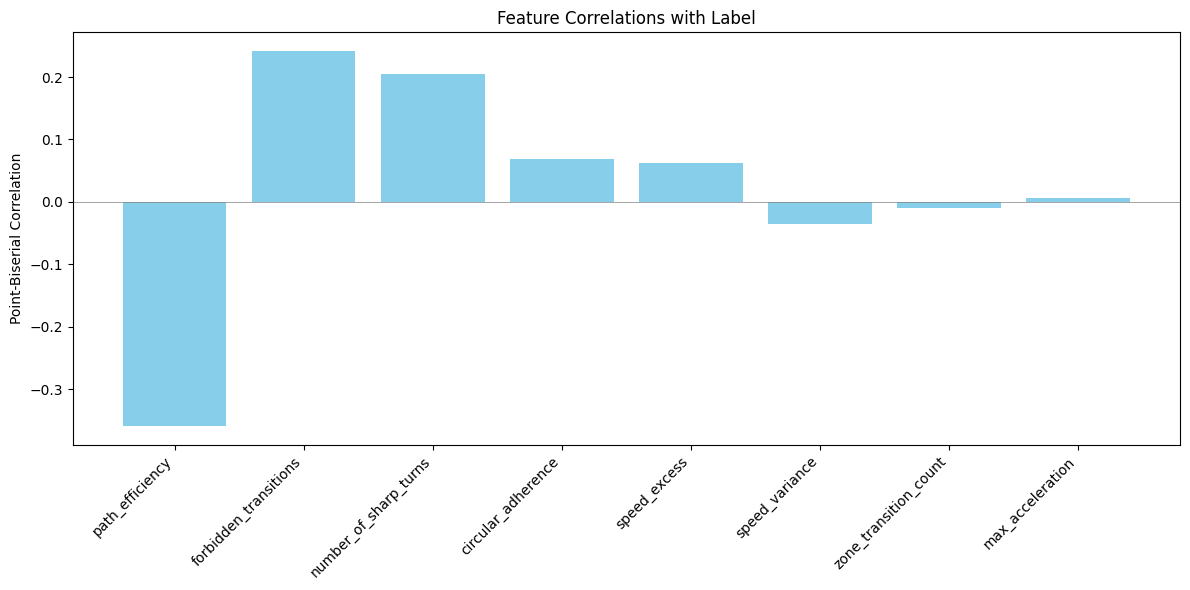

In [8]:
features_df = pd.read_csv(results_path)  # Assume pre-saved from Cell 3
numeric_cols = features_df.select_dtypes(include=[np.number]).columns
constant_cols = [col for col in numeric_cols if features_df[col].nunique() <= 1 or features_df[col].sum() == 0]
cleaned_df = features_df.drop(columns=constant_cols)

X = cleaned_df.drop(columns=['track_id', 'label'])
y = cleaned_df['label']
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = ['zone_sequence']

print("\nCleaned Data Sample:")
print(cleaned_df.head())

normal_group = cleaned_df[cleaned_df['label'] == 0]
abnormal_group = cleaned_df[cleaned_df['label'] == 1]
stats_df = pd.DataFrame({
    'Mean_Normal': normal_group[numeric_features].mean(),
    'Std_Normal': normal_group[numeric_features].std(),
    'Mean_Abnormal': abnormal_group[numeric_features].mean(),
    'Std_Abnormal': abnormal_group[numeric_features].std()
})
print("\nStatistical Summary:")
print(stats_df)

correlations = {col: pointbiserialr(y, X[col])[0] for col in numeric_features}
corr_df = pd.DataFrame(list(correlations.items()), columns=['Feature', 'Correlation']).sort_values(by='Correlation', key=abs, ascending=False)
print("\nPoint-Biserial Correlation with Label:")
print(corr_df)

plt.figure(figsize=(12, 6))
plt.bar(corr_df['Feature'], corr_df['Correlation'], color='skyblue')
plt.axhline(0, color='gray', linewidth=0.5)
plt.xticks(rotation=45, ha='right')
plt.title('Feature Correlations with Label')
plt.ylabel('Point-Biserial Correlation')
plt.tight_layout()
plt.show()

In [9]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[numeric_features])

# DBSCAN for anomaly detection
db = DBSCAN(eps=0.5, min_samples=5).fit(X_scaled)
cluster_labels = db.labels_  # -1 for outliers
initial_preds = [1 if label == -1 else 0 for label in cluster_labels]

# Refine with Random Forest
X_train, X_test, y_train, y_test = train_test_split(X[numeric_features], y, test_size=0.2, random_state=42)
clf = RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("\nHybrid Classification Results:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

# Feature importance
importances = pd.DataFrame({'Feature': numeric_features, 'Importance': clf.feature_importances_})
print("\nFeature Importances:")
print(importances.sort_values(by='Importance', ascending=False))


Hybrid Classification Results:
              precision    recall  f1-score   support

           0       0.85      0.84      0.84       119
           1       0.53      0.54      0.53        39

    accuracy                           0.77       158
   macro avg       0.69      0.69      0.69       158
weighted avg       0.77      0.77      0.77       158

Accuracy: 0.77

Feature Importances:
                 Feature  Importance
3        path_efficiency    0.211277
2     circular_adherence    0.190524
6  forbidden_transitions    0.144262
0         speed_variance    0.121426
1       max_acceleration    0.116772
4  number_of_sharp_turns    0.113944
5  zone_transition_count    0.097156
7           speed_excess    0.004639
